In [ ]:
!pip install kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d slothkong/10-monkey-species

!unzip 10-monkey-species.zip -d ./monkey-species

Dataset URL: https://www.kaggle.com/datasets/slothkong/10-monkey-species
License(s): CC0-1.0
 97% 532M/547M [00:03<00:00, 169MB/s]
100% 547M/547M [00:03<00:00, 174MB/s]
Archive:  10-monkey-species.zip
  inflating: ./monkey-species/monkey_labels.txt  
  inflating: ./monkey-species/training/training/n0/n0018.jpg  
  inflating: ./monkey-species/training/training/n0/n0019.jpg  
  inflating: ./monkey-species/training/training/n0/n0020.jpg  
  inflating: ./monkey-species/training/training/n0/n0021.jpg  
  inflating: ./monkey-species/training/training/n0/n0022.jpg  
  inflating: ./monkey-species/training/training/n0/n0023.jpg  
  inflating: ./monkey-species/training/training/n0/n0024.jpg  
  inflating: ./monkey-species/training/training/n0/n0025.jpg  
  inflating: ./monkey-species/training/training/n0/n0026.jpg  
  inflating: ./monkey-species/training/training/n0/n0027.jpg  
  inflating: ./monkey-species/training/training/n0/n0028.jpg  
  inflating: ./monkey-species/training/training/n0/n0029

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
train_dir = './monkey-species/training/training'
val_dir = './monkey-species/validation/validation'

In [ ]:
height=150
width=150
seed=2000
batch_size = 64

train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=40,
        horizontal_flip=True,
        fill_mode='nearest'
)

train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height,width),
    batch_size=batch_size,
    seed=seed,
    shuffle=True,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_ds = val_datagen.flow_from_directory(
    val_dir,
    target_size=(height,width),
    batch_size=batch_size,
    seed=seed,
    shuffle=False,
    class_mode='categorical'
)

train_num = train_ds.samples
validation_num = val_ds.samples

print (train_num)
print (validation_num)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
1098
272


In [ ]:
model = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    Dropout(0.35),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 dropout (Dropout)           (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       7

In [ ]:
filepath = os.path.join(os.getcwd(), "best_model.keras")
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='max'
)

history=model.fit(
    train_ds,
    epochs=200,
    steps_per_epoch=train_num//batch_size,
    validation_steps=validation_num//batch_size,
    validation_data=val_ds,
    callbacks=[checkpoint],
)

Epoch 1/200
17/17 [==============================] - ETA: 0s - loss: 2.5240 - acc: 0.1315
Epoch 1: val_acc improved from -inf to 0.13672, saving model to /content/best_model.keras
17/17 [==============================] - 26s 2s/step - loss: 2.5240 - acc: 0.1315 - val_loss: 2.2569 - val_acc: 0.1367
Epoch 2/200
17/17 [==============================] - ETA: 0s - loss: 2.2036 - acc: 0.2176
Epoch 2: val_acc improved from 0.13672 to 0.32422, saving model to /content/best_model.keras
17/17 [==============================] - 24s 1s/step - loss: 2.2036 - acc: 0.2176 - val_loss: 2.0789 - val_acc: 0.3242
Epoch 3/200
17/17 [==============================] - ETA: 0s - loss: 2.0270 - acc: 0.2776
Epoch 3: val_acc improved from 0.32422 to 0.38672, saving model to /content/best_model.keras
17/17 [==============================] - 24s 1s/step - loss: 2.0270 - acc: 0.2776 - val_loss: 1.9345 - val_acc: 0.3867
Epoch 4/200
17/17 [==============================] - ETA: 0s - loss: 1.9123 - acc: 0.3143
Epoch 4

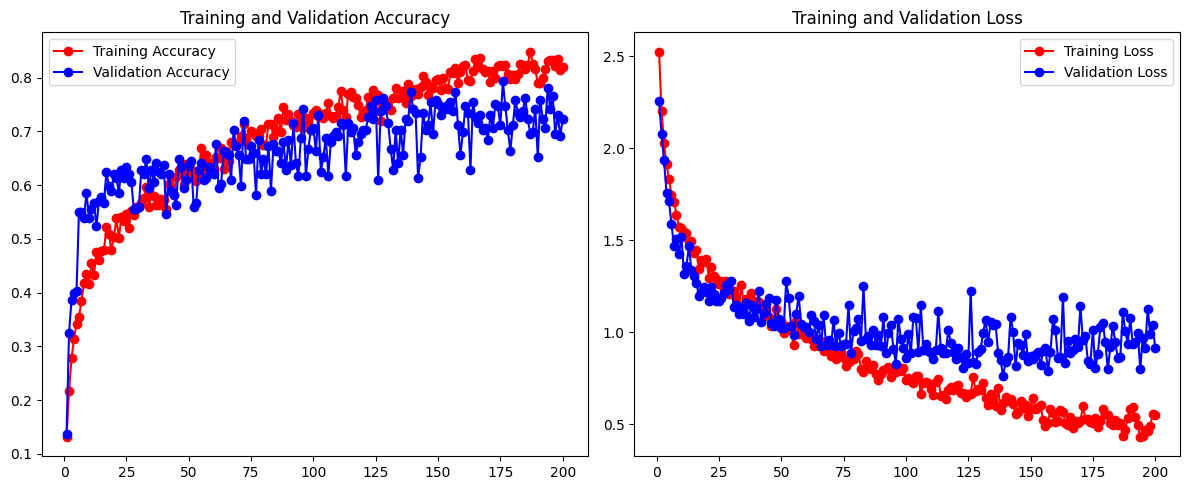

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'red', label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, 'blue', label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'red', label='Training Loss', marker='o')
plt.plot(epochs, val_loss, 'blue', label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

5/5 [==============================] - 4s 807ms/step


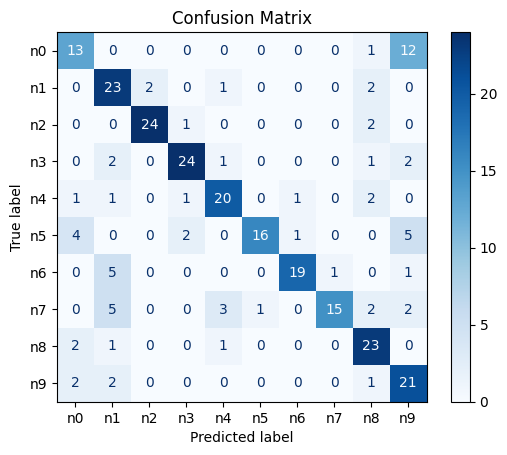

In [ ]:
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_ds.classes

cm = confusion_matrix(y_true, y_pred_classes)
labels = list(val_ds.class_indices.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 29ms/step


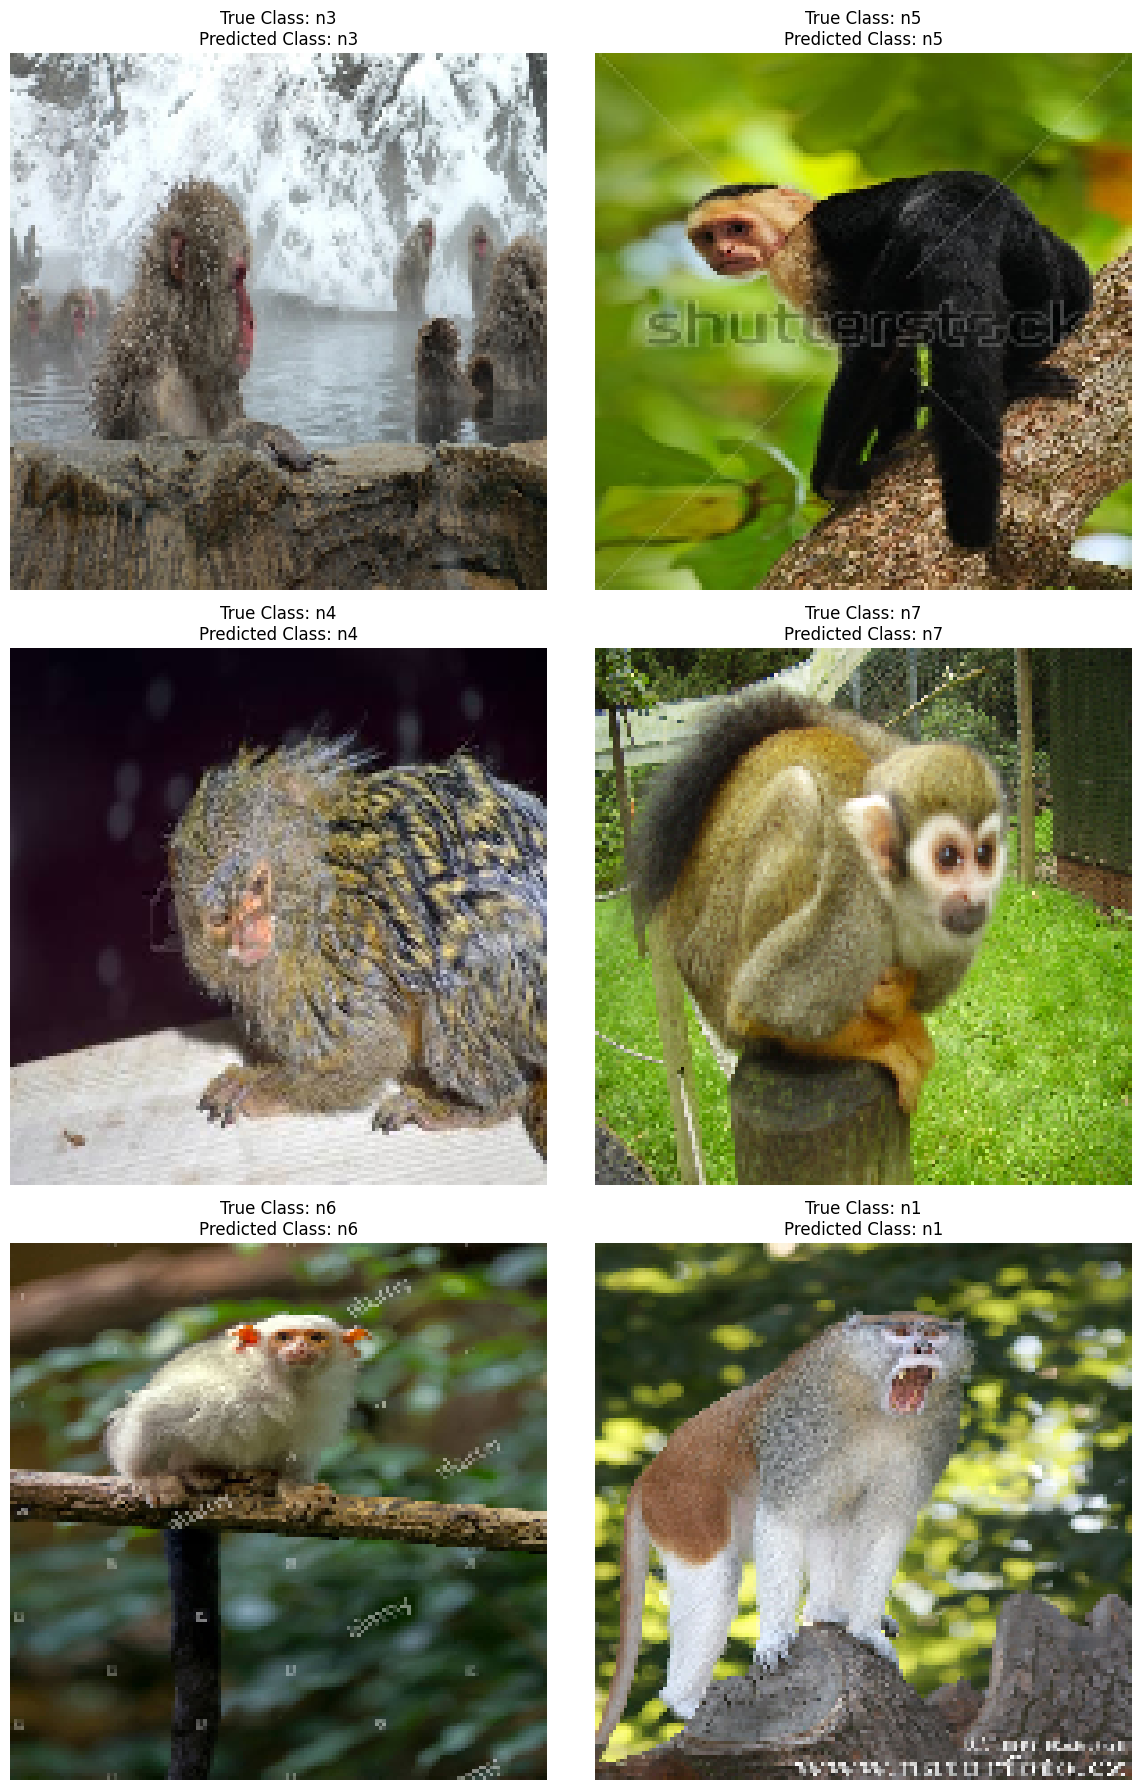

In [ ]:
sample_indexes = random.sample(range(train_num), 6)
plt.figure(figsize=(12, 18))

for i, idx in enumerate(sample_indexes):
    img_path = train_ds.filepaths[idx]
    true_class_idx = train_ds.labels[idx]
    true_class_label = list(train_ds.class_indices.keys())[true_class_idx]

    img = image.load_img(img_path, target_size=(height, width))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    predicted_class_label = list(train_ds.class_indices.keys())[predicted_class]

    plt.subplot(3, 2, i + 1)
    plt.imshow(img)
    plt.title(f"True Class: {true_class_label}\nPredicted Class: {predicted_class_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()